In [1]:
import numpy as np
import pandas as pd
import random
import os
import sys
import matplotlib.pyplot as plt

from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as keras

from sklearn.model_selection import train_test_split

# data preparation for dicty
from prepare_data import *

sys.path.insert(0, os.getcwd().rsplit('/',1)[0])
import loops_utils

# load unet model
from unet_model import *

Using TensorFlow backend.


In [2]:
%matplotlib inline

In [5]:
def eval_model(image_size, is_log = False, is_norm_over_diagonals = True):
    
    X_train, y_train = prepare_data(image_size, chromosomes=[1,5], is_log=is_log, is_norm_over_diagonals=is_norm_over_diagonals)

    # Split val & test
    X, y = prepare_data(image_size, chromosomes=[6], is_log=is_log, is_norm_over_diagonals=is_norm_over_diagonals)
    X_valid, X_test, y_valid, y_test = train_test_split(X, y, test_size=0.5, random_state=1)
    

    input_img = Input((image_size, image_size, 1), name='img')
    model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    weights_path = 'weights/model_unet_' + str(image_size)
    if is_norm_over_diagonals:
        weights_path += '_norm'
    if is_log:
        weights_path += '_log'
    weights_path += '.h5'
    
    
    callbacks = [
        EarlyStopping(patience=10, verbose=1),
        ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
        ModelCheckpoint(weights_path, verbose=1, save_best_only=True, save_weights_only=True)
    ]

    results = model.fit(X_train, y_train, batch_size=1, epochs=100, callbacks=callbacks, 
                        validation_data=(X_valid, y_valid))

    plot_model_scores(results)

    model.load_weights(weights_path)
    score, acc = model.evaluate(X_test, y_test, verbose=0)
    
    print('Test score:', score)
    print('Test accuracy:', acc)

    # Predict on train, val and test
    preds_train = model.predict(X_train, verbose=1)
    preds_test = model.predict(X_test, verbose=1)

    # Threshold predictions
    preds_train_t = (preds_train > 0.5).astype(np.uint8)
    preds_test_t = (preds_test > 0.5).astype(np.uint8)
    
    print('Train example 1')
    name = 'Unet_dicty_'+ str(image_size) + '_train_pred_1'
    if is_norm_over_diagonals:
        name += '_norm'
    if is_log:
        name += '_log'
    loops_utils.plot_prediction_HiC(X_train[10,:,:,:],
                                y_train[10,:,:,:],
                                preds_train[10,:,:,:],
                                preds_train_t[10,:,:,:],
                                image_size=image_size,
                                name=name,
                                is_log_HiC = not is_log)
    
    print('Test example 1')
    name = 'Unet_dicty_'+ str(image_size) + '_test_pred_1'
    if is_norm_over_diagonals:
        name += '_norm'
    if is_log:
        name += '_log'
    loops_utils.plot_prediction_HiC(X_test[2,:,:,:],
                                y_test[2,:,:,:],
                                preds_test[2,:,:,:],
                                preds_test_t[2,:,:,:],
                                image_size=image_size,
                                name=name,
                                is_log_HiC = not is_log)

NOT log, normalized over diagonals

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 158 samples, validate on 28 samples
Epoch 1/100
158/158 [==============================] - 71s 447ms/step - loss: 0.4391 - acc: 0.7880 - val_loss: 0.4055 - val_acc: 0.8242

Epoch 00001: val_loss improved from inf to 0.40547, saving model to weights/model_unet_32_norm.h5
Epoch 2/100
158/158 [==============================] - 30s 190ms/step - loss: 0.3552 - acc: 0.8391 - val_loss: 0.4112 - val_acc: 0.8198

Epoch 00002: val_loss did not improve from 0.40547
Epoch 3/100
158/158 [==============================] - 27s 173ms/step - loss: 0.3436 - acc: 0.8448 - val_loss: 0.4057 - val_acc: 0.8261

Epoch 00003: val_loss did not improve from 0.40547
Epoch 4/100
158/158 [==============================] - 29s 184ms/step - loss: 0.3309 - acc: 0.8505 - val_loss

/Users/alex/Desktop/ws/hse/diploma/loops/loops_utils.py:62: RuntimeWarning: divide by zero encountered in log
  raw = np.log(raw)


Test example 1


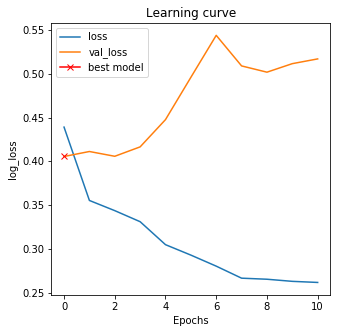

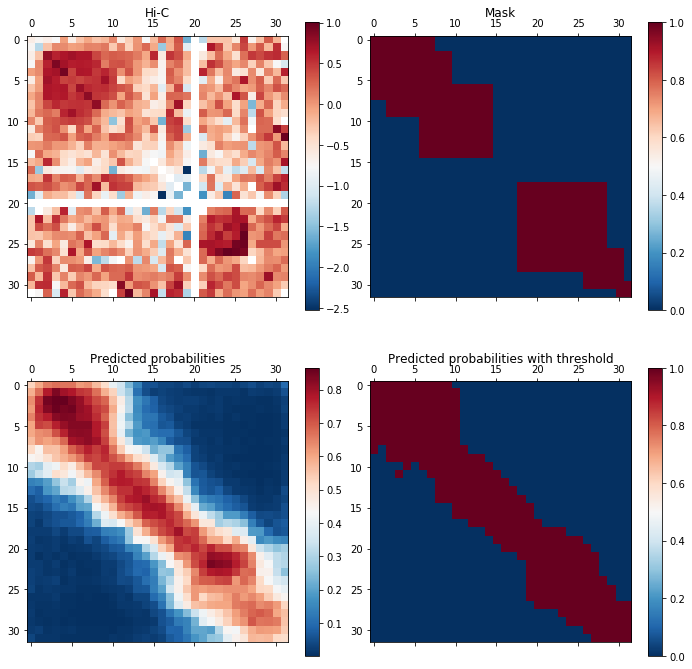

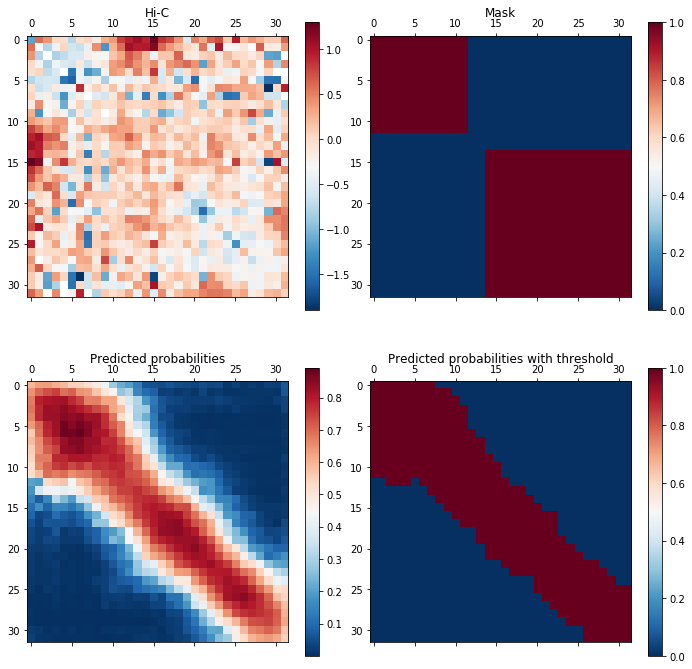

In [6]:
eval_model(image_size = 32, is_log=False, is_norm_over_diagonals=True)

Train on 80 samples, validate on 14 samples
Epoch 1/100
80/80 [==============================] - 66s 823ms/step - loss: 0.5231 - acc: 0.7780 - val_loss: 0.3373 - val_acc: 0.9028

Epoch 00001: val_loss improved from inf to 0.33734, saving model to weights/model_unet_64_norm.h5
Epoch 2/100
80/80 [==============================] - 19s 238ms/step - loss: 0.2917 - acc: 0.9087 - val_loss: 0.3348 - val_acc: 0.9005

Epoch 00002: val_loss improved from 0.33734 to 0.33476, saving model to weights/model_unet_64_norm.h5
Epoch 3/100
80/80 [==============================] - 19s 242ms/step - loss: 0.2348 - acc: 0.9157 - val_loss: 0.2518 - val_acc: 0.9001

Epoch 00003: val_loss improved from 0.33476 to 0.25178, saving model to weights/model_unet_64_norm.h5
Epoch 4/100
80/80 [==============================] - 18s 226ms/step - loss: 0.2106 - acc: 0.9174 - val_loss: 0.2236 - val_acc: 0.8907

Epoch 00004: val_loss improved from 0.25178 to 0.22360, saving model to weights/model_unet_64_norm.h5
Epoch 5/100


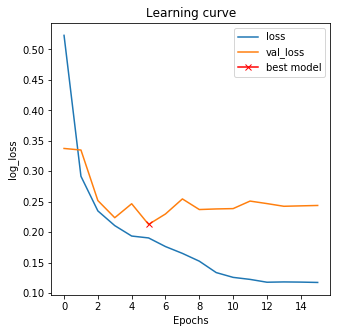

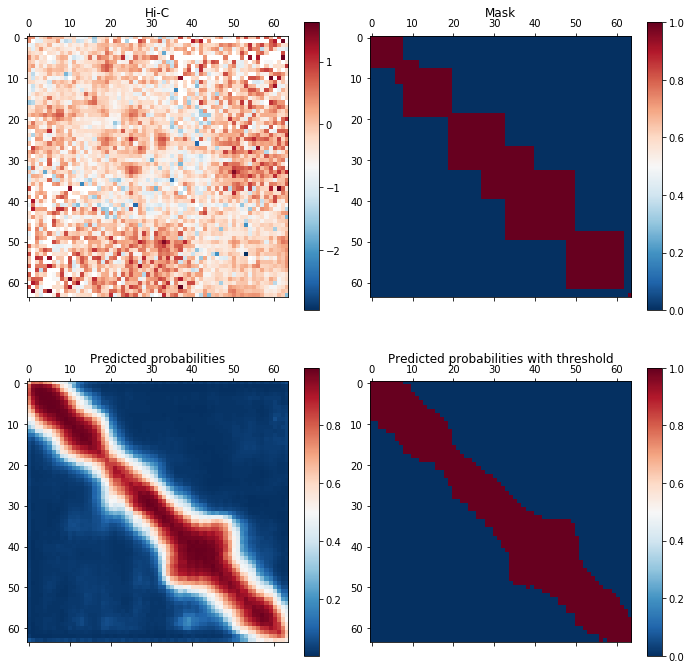

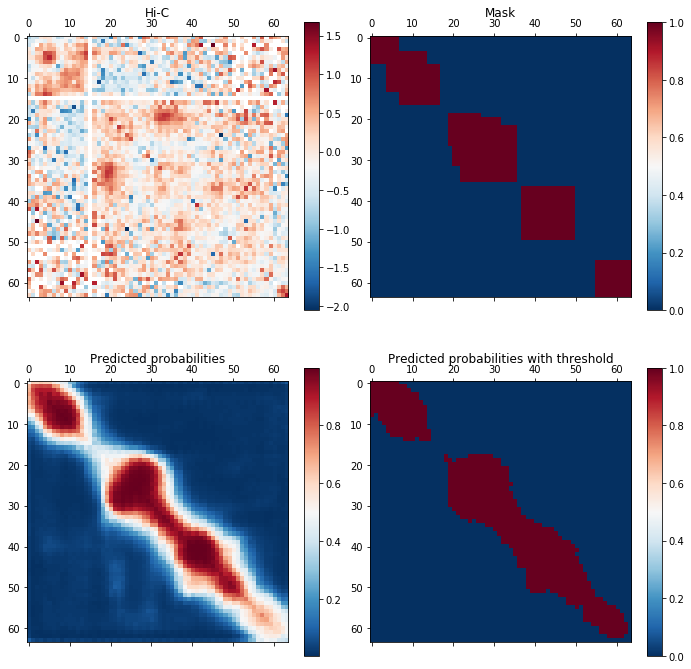

In [7]:
eval_model(image_size = 64, is_log=False, is_norm_over_diagonals=True)

Train on 41 samples, validate on 7 samples
Epoch 1/100
41/41 [==============================] - 56s 1s/step - loss: 0.4429 - acc: 0.8487 - val_loss: 0.3416 - val_acc: 0.8849

Epoch 00001: val_loss improved from inf to 0.34159, saving model to weights/model_unet_128_norm.h5
Epoch 2/100
41/41 [==============================] - 17s 415ms/step - loss: 0.2753 - acc: 0.9376 - val_loss: 0.4029 - val_acc: 0.8638

Epoch 00002: val_loss did not improve from 0.34159
Epoch 3/100
41/41 [==============================] - 20s 495ms/step - loss: 0.2152 - acc: 0.9470 - val_loss: 0.1869 - val_acc: 0.9452

Epoch 00003: val_loss improved from 0.34159 to 0.18693, saving model to weights/model_unet_128_norm.h5
Epoch 4/100
41/41 [==============================] - 20s 491ms/step - loss: 0.1800 - acc: 0.9516 - val_loss: 0.1695 - val_acc: 0.9434

Epoch 00004: val_loss improved from 0.18693 to 0.16950, saving model to weights/model_unet_128_norm.h5
Epoch 5/100
41/41 [==============================] - 22s 542ms/s

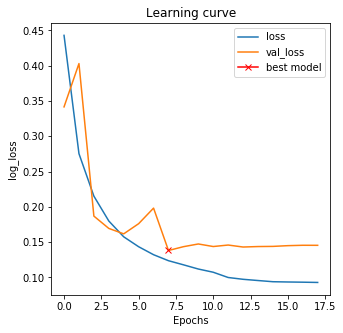

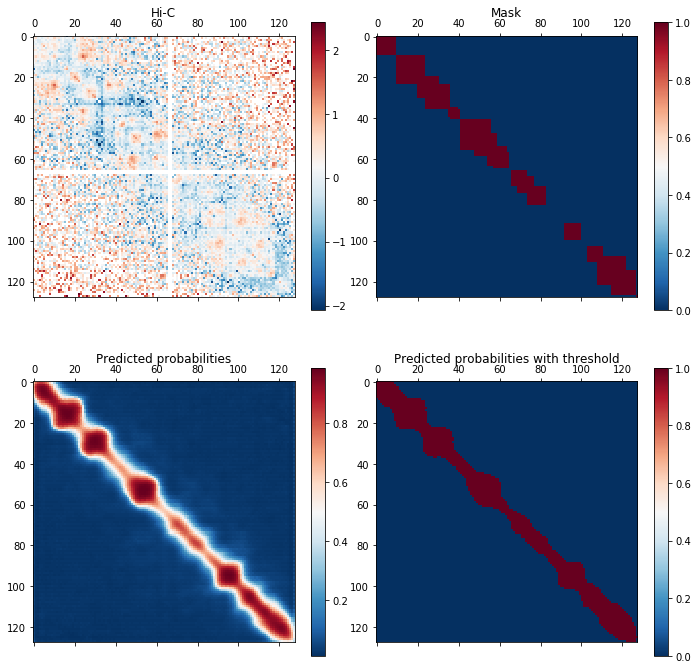

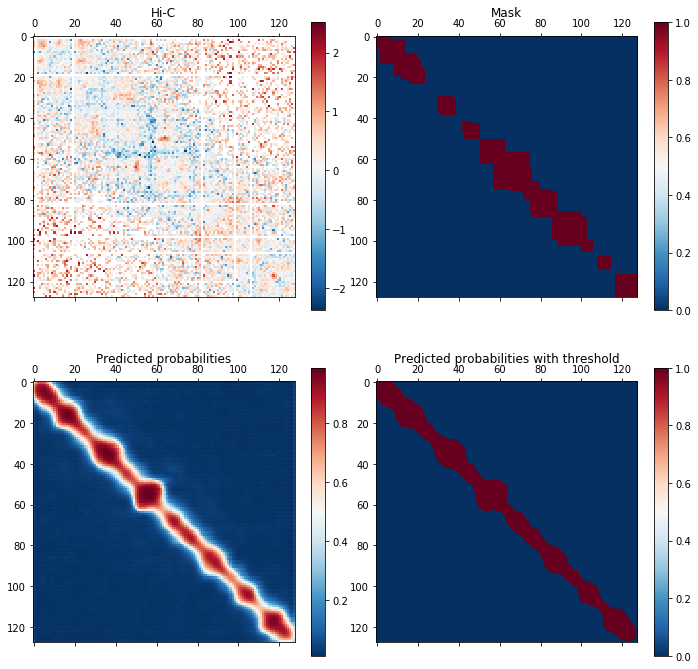

In [8]:
eval_model(image_size = 128, is_log=False, is_norm_over_diagonals=True)

Train on 21 samples, validate on 4 samples
Epoch 1/100
21/21 [==============================] - 90s 4s/step - loss: 0.4207 - acc: 0.8879 - val_loss: 0.3043 - val_acc: 0.9295

Epoch 00001: val_loss improved from inf to 0.30427, saving model to weights/model_unet_256_norm.h5
Epoch 2/100
21/21 [==============================] - 26s 1s/step - loss: 0.2505 - acc: 0.9647 - val_loss: 0.2109 - val_acc: 0.9534

Epoch 00002: val_loss improved from 0.30427 to 0.21091, saving model to weights/model_unet_256_norm.h5
Epoch 3/100
21/21 [==============================] - 27s 1s/step - loss: 0.1723 - acc: 0.9711 - val_loss: 0.2368 - val_acc: 0.8836

Epoch 00003: val_loss did not improve from 0.21091
Epoch 4/100
21/21 [==============================] - 28s 1s/step - loss: 0.1457 - acc: 0.9708 - val_loss: 0.1498 - val_acc: 0.9538

Epoch 00004: val_loss improved from 0.21091 to 0.14975, saving model to weights/model_unet_256_norm.h5
Epoch 5/100
21/21 [==============================] - 30s 1s/step - loss: 

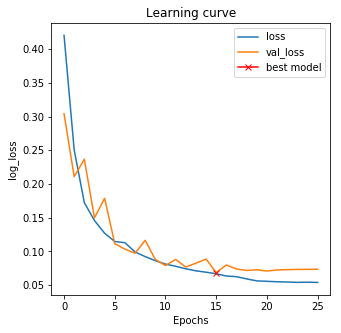

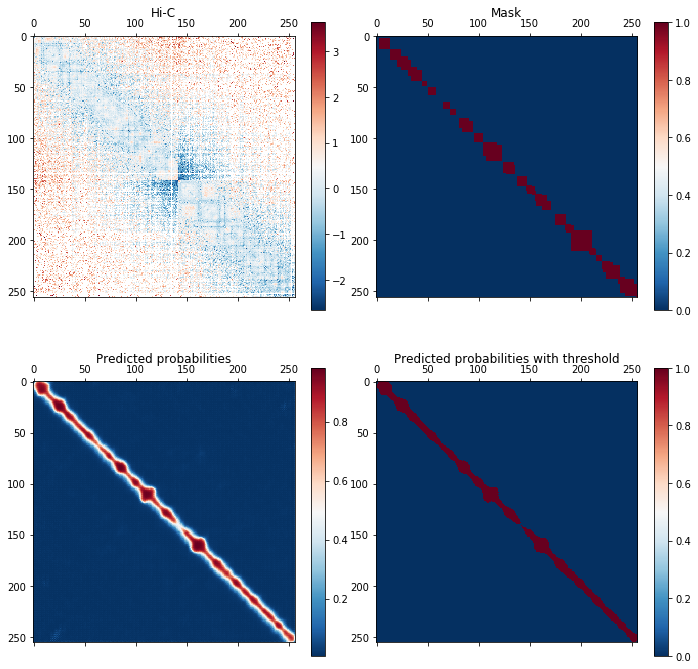

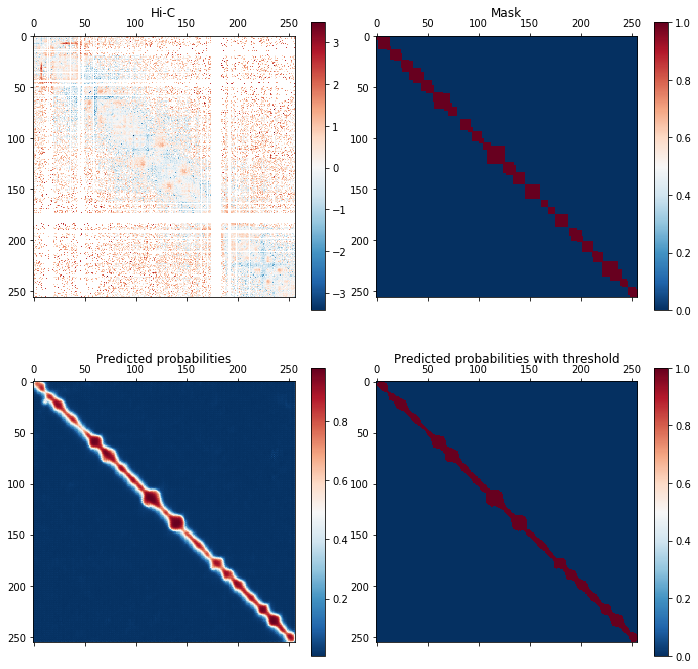

In [9]:
eval_model(image_size = 256, is_log=False, is_norm_over_diagonals=True)

NOT log, NOT normalized over diagonals

Train on 158 samples, validate on 28 samples
Epoch 1/100
158/158 [==============================] - 78s 493ms/step - loss: 0.4577 - acc: 0.8027 - val_loss: 0.4195 - val_acc: 0.8099

Epoch 00001: val_loss improved from inf to 0.41945, saving model to weights/model_unet_32.h5
Epoch 2/100
158/158 [==============================] - 31s 194ms/step - loss: 0.3794 - acc: 0.8278 - val_loss: 0.4534 - val_acc: 0.7728

Epoch 00002: val_loss did not improve from 0.41945
Epoch 3/100
158/158 [==============================] - 33s 211ms/step - loss: 0.3587 - acc: 0.8357 - val_loss: 0.4570 - val_acc: 0.7751

Epoch 00003: val_loss did not improve from 0.41945
Epoch 4/100
158/158 [==============================] - 32s 201ms/step - loss: 0.3475 - acc: 0.8413 - val_loss: 0.3911 - val_acc: 0.8211

Epoch 00004: val_loss improved from 0.41945 to 0.39113, saving model to weights/model_unet_32.h5
Epoch 5/100
158/158 [==============================] - 33s 211ms/step - loss: 0.3371 - acc: 0.8464 - val_loss: 0.40

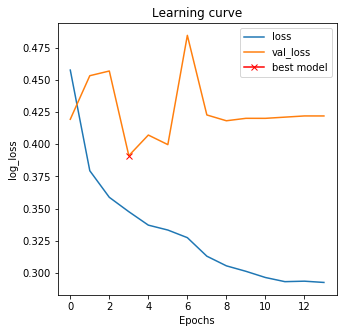

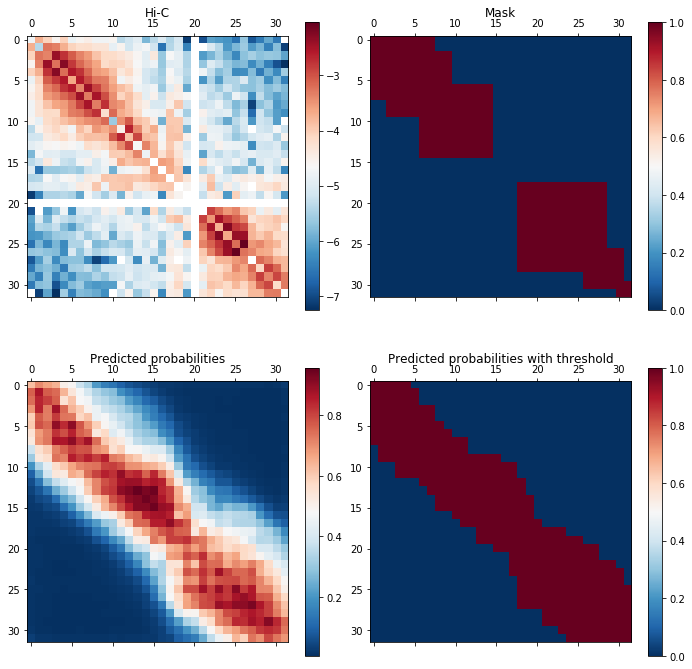

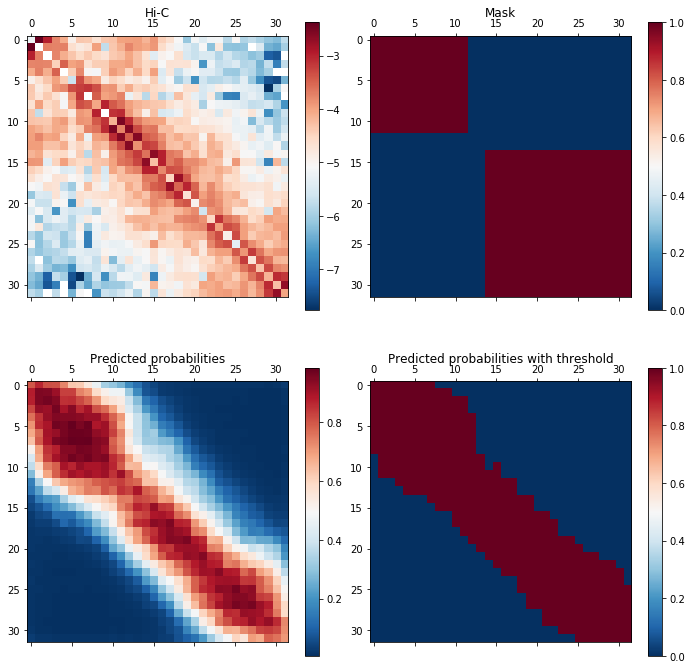

In [10]:
eval_model(image_size = 32, is_log=False, is_norm_over_diagonals=False)

Train on 80 samples, validate on 14 samples
Epoch 1/100
80/80 [==============================] - 59s 731ms/step - loss: 0.5851 - acc: 0.8190 - val_loss: 0.5120 - val_acc: 0.8519

Epoch 00001: val_loss improved from inf to 0.51200, saving model to weights/model_unet_64.h5
Epoch 2/100
80/80 [==============================] - 18s 223ms/step - loss: 0.4036 - acc: 0.8942 - val_loss: 0.3811 - val_acc: 0.9078

Epoch 00002: val_loss improved from 0.51200 to 0.38107, saving model to weights/model_unet_64.h5
Epoch 3/100
80/80 [==============================] - 17s 212ms/step - loss: 0.3274 - acc: 0.9024 - val_loss: 0.3105 - val_acc: 0.9066

Epoch 00003: val_loss improved from 0.38107 to 0.31048, saving model to weights/model_unet_64.h5
Epoch 4/100
80/80 [==============================] - 18s 220ms/step - loss: 0.2798 - acc: 0.9041 - val_loss: 0.2900 - val_acc: 0.9099

Epoch 00004: val_loss improved from 0.31048 to 0.28996, saving model to weights/model_unet_64.h5
Epoch 5/100
80/80 [=============

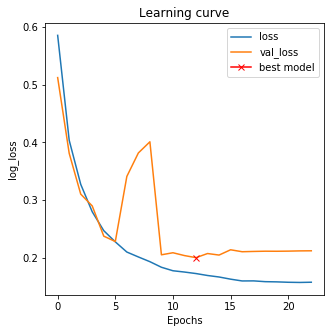

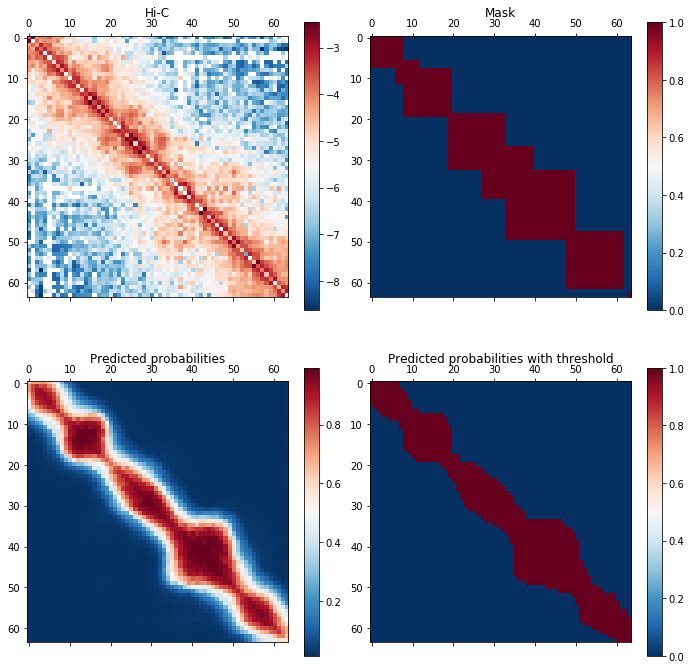

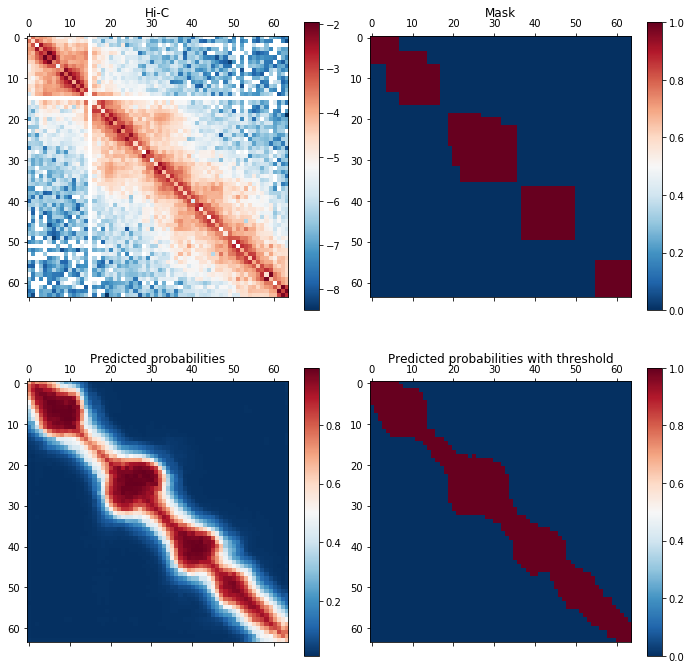

In [11]:
eval_model(image_size = 64, is_log=False, is_norm_over_diagonals=False)

Train on 41 samples, validate on 7 samples
Epoch 1/100
41/41 [==============================] - 55s 1s/step - loss: 0.3684 - acc: 0.9292 - val_loss: 0.3178 - val_acc: 0.9354

Epoch 00001: val_loss improved from inf to 0.31779, saving model to weights/model_unet_128.h5
Epoch 2/100
41/41 [==============================] - 15s 377ms/step - loss: 0.2443 - acc: 0.9468 - val_loss: 0.2292 - val_acc: 0.9366

Epoch 00002: val_loss improved from 0.31779 to 0.22921, saving model to weights/model_unet_128.h5
Epoch 3/100
41/41 [==============================] - 15s 370ms/step - loss: 0.1958 - acc: 0.9477 - val_loss: 0.1842 - val_acc: 0.9438

Epoch 00003: val_loss improved from 0.22921 to 0.18415, saving model to weights/model_unet_128.h5
Epoch 4/100
41/41 [==============================] - 16s 388ms/step - loss: 0.1650 - acc: 0.9498 - val_loss: 0.1684 - val_acc: 0.9398

Epoch 00004: val_loss improved from 0.18415 to 0.16841, saving model to weights/model_unet_128.h5
Epoch 5/100
41/41 [=============

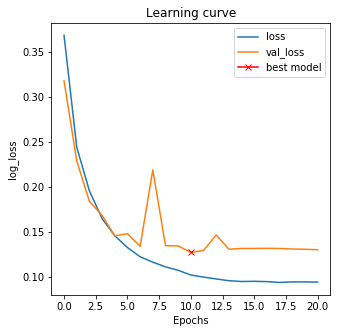

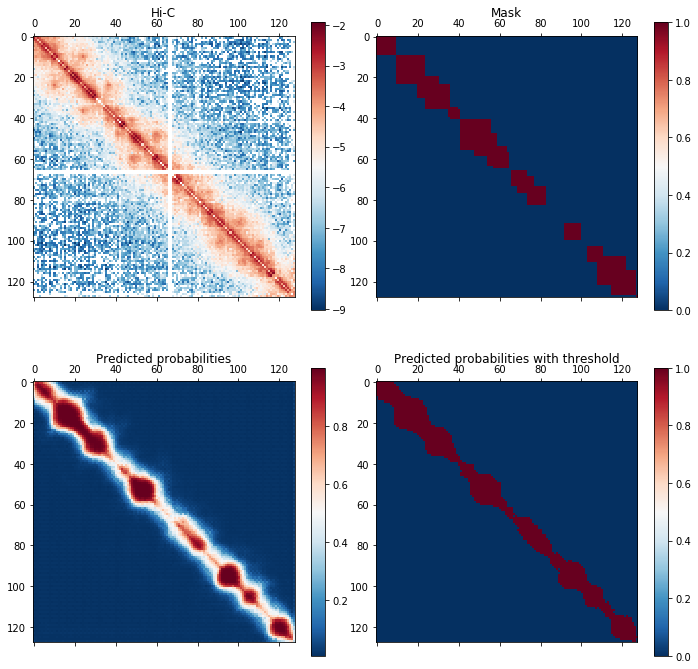

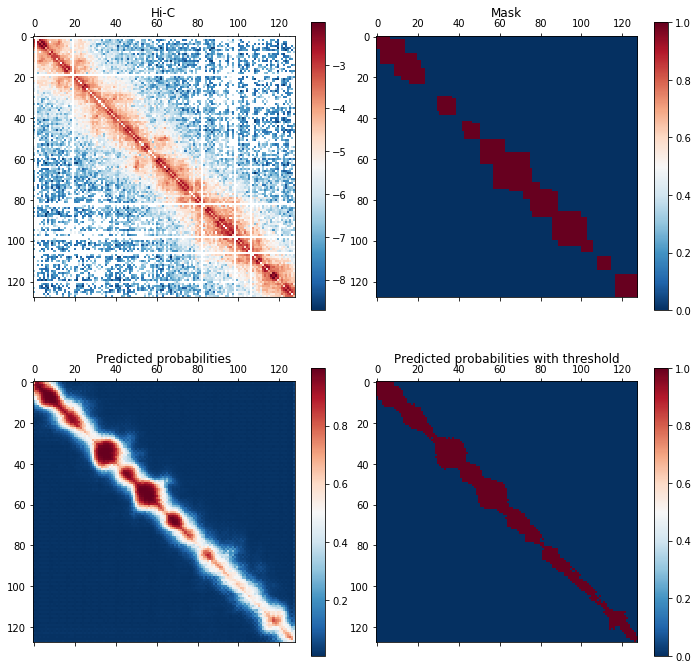

In [12]:
eval_model(image_size = 128, is_log=False, is_norm_over_diagonals=False)

Train on 21 samples, validate on 4 samples
Epoch 1/100
21/21 [==============================] - 57s 3s/step - loss: 0.5226 - acc: 0.8774 - val_loss: 0.3535 - val_acc: 0.9645

Epoch 00001: val_loss improved from inf to 0.35354, saving model to weights/model_unet_256.h5
Epoch 2/100
21/21 [==============================] - 22s 1s/step - loss: 0.3459 - acc: 0.9710 - val_loss: 0.2839 - val_acc: 0.9726

Epoch 00002: val_loss improved from 0.35354 to 0.28392, saving model to weights/model_unet_256.h5
Epoch 3/100
21/21 [==============================] - 27s 1s/step - loss: 0.2872 - acc: 0.9729 - val_loss: 0.2591 - val_acc: 0.9740

Epoch 00003: val_loss improved from 0.28392 to 0.25907, saving model to weights/model_unet_256.h5
Epoch 4/100
21/21 [==============================] - 29s 1s/step - loss: 0.2468 - acc: 0.9730 - val_loss: 0.2300 - val_acc: 0.9730

Epoch 00004: val_loss improved from 0.25907 to 0.23002, saving model to weights/model_unet_256.h5
Epoch 5/100
21/21 [======================

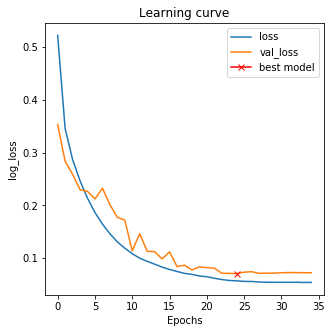

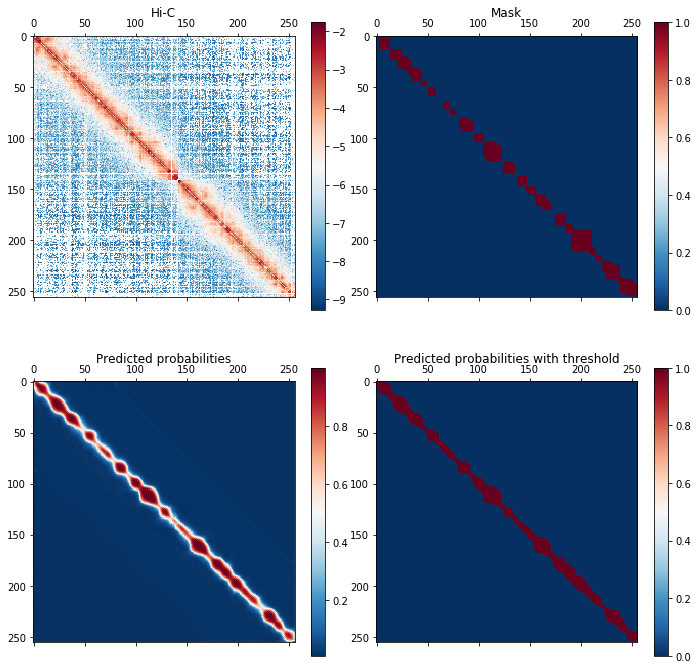

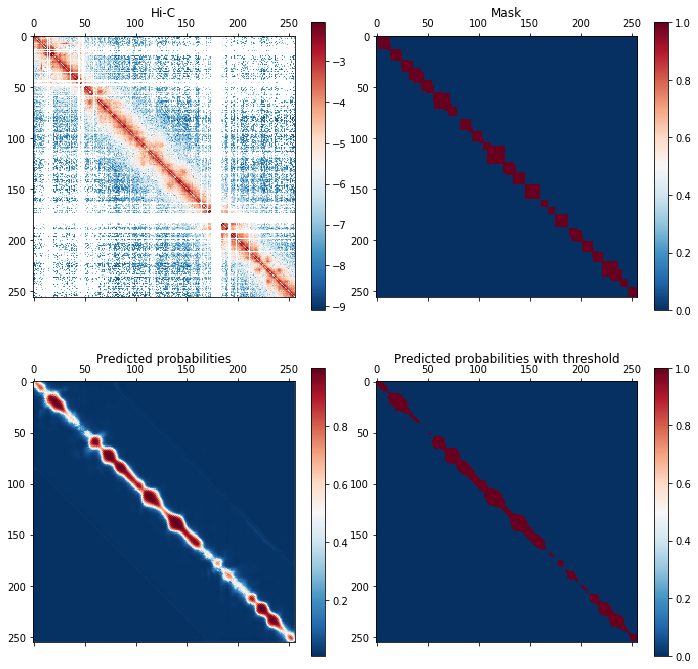

In [13]:
eval_model(image_size = 256, is_log=False, is_norm_over_diagonals=False)

log, NOT normalized over diagonals

Train on 158 samples, validate on 28 samples
Epoch 1/100
158/158 [==============================] - 94s 594ms/step - loss: 0.4300 - acc: 0.7961 - val_loss: 0.4696 - val_acc: 0.8061

Epoch 00001: val_loss improved from inf to 0.46963, saving model to weights/model_unet_32_log.h5
Epoch 2/100
158/158 [==============================] - 31s 198ms/step - loss: 0.3775 - acc: 0.8243 - val_loss: 0.4245 - val_acc: 0.8099

Epoch 00002: val_loss improved from 0.46963 to 0.42447, saving model to weights/model_unet_32_log.h5
Epoch 3/100
158/158 [==============================] - 29s 183ms/step - loss: 0.3624 - acc: 0.8294 - val_loss: 0.4562 - val_acc: 0.8084

Epoch 00003: val_loss did not improve from 0.42447
Epoch 4/100
158/158 [==============================] - 27s 173ms/step - loss: 0.3530 - acc: 0.8379 - val_loss: 0.4342 - val_acc: 0.8098

Epoch 00004: val_loss did not improve from 0.42447
Epoch 5/100
158/158 [==============================] - 30s 188ms/step - loss: 0.3469 - acc: 0.8399 - val_lo

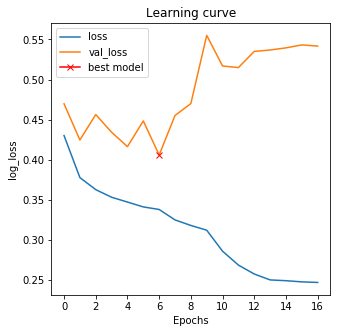

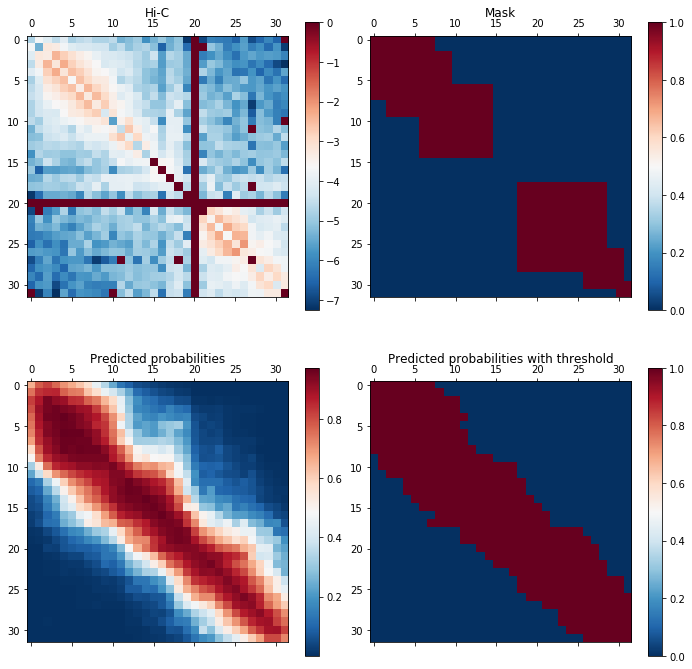

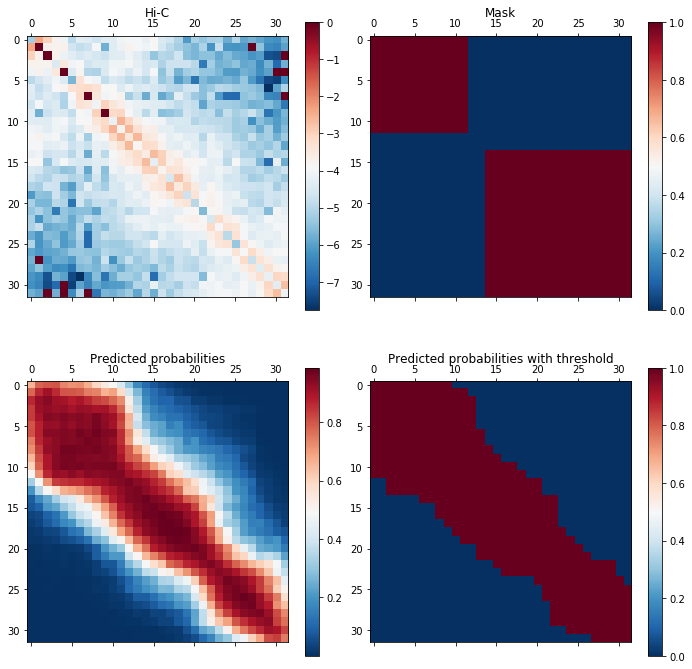

In [14]:
eval_model(image_size = 32, is_log=True, is_norm_over_diagonals=False)

Train on 80 samples, validate on 14 samples
Epoch 1/100
80/80 [==============================] - 71s 885ms/step - loss: 0.5646 - acc: 0.6980 - val_loss: 0.4749 - val_acc: 0.8178

Epoch 00001: val_loss improved from inf to 0.47488, saving model to weights/model_unet_64_log.h5
Epoch 2/100
80/80 [==============================] - 18s 219ms/step - loss: 0.3419 - acc: 0.8811 - val_loss: 0.3040 - val_acc: 0.8973

Epoch 00002: val_loss improved from 0.47488 to 0.30396, saving model to weights/model_unet_64_log.h5
Epoch 3/100
80/80 [==============================] - 17s 213ms/step - loss: 0.2783 - acc: 0.9008 - val_loss: 0.2709 - val_acc: 0.8994

Epoch 00003: val_loss improved from 0.30396 to 0.27089, saving model to weights/model_unet_64_log.h5
Epoch 4/100
80/80 [==============================] - 18s 228ms/step - loss: 0.2475 - acc: 0.9029 - val_loss: 0.2734 - val_acc: 0.8875

Epoch 00004: val_loss did not improve from 0.27089
Epoch 5/100
80/80 [==============================] - 18s 220ms/ste

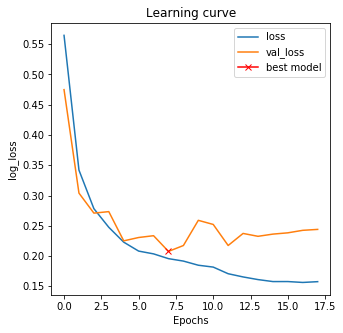

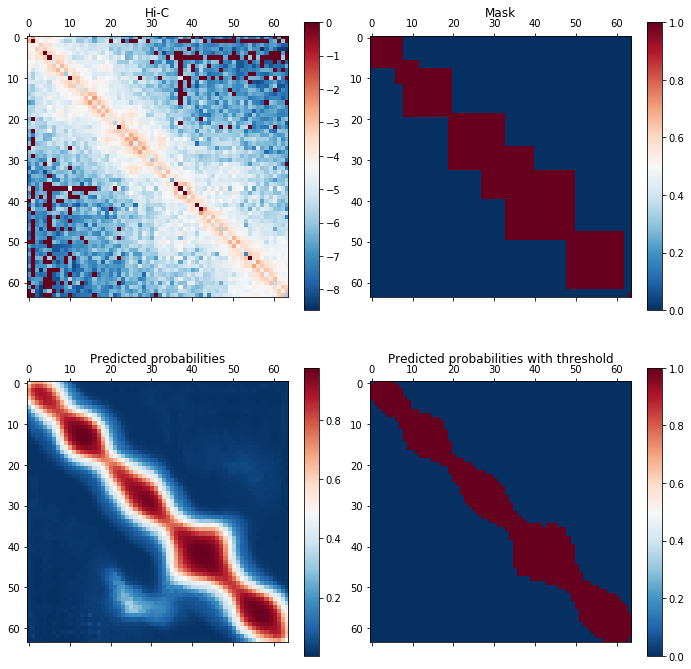

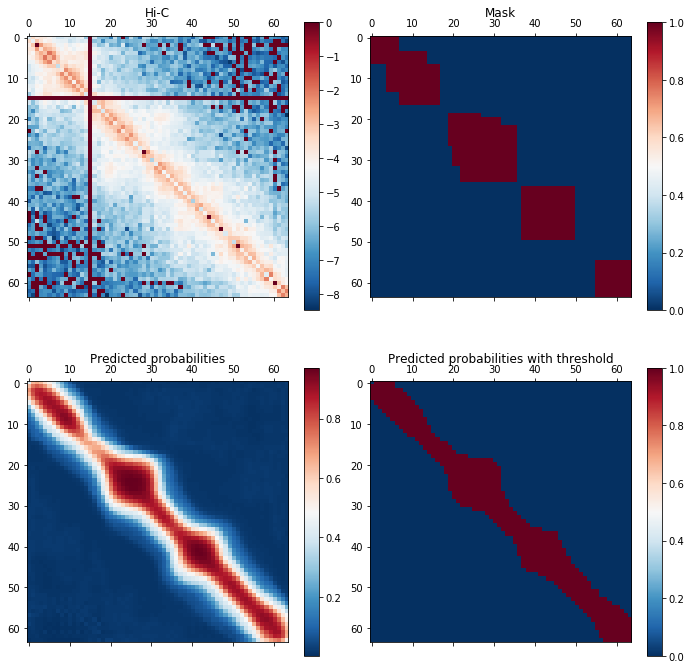

In [15]:
eval_model(image_size = 64, is_log=True, is_norm_over_diagonals=False)

Train on 41 samples, validate on 7 samples
Epoch 1/100
41/41 [==============================] - 81s 2s/step - loss: 0.6511 - acc: 0.6751 - val_loss: 0.6753 - val_acc: 0.7804

Epoch 00001: val_loss improved from inf to 0.67534, saving model to weights/model_unet_128_log.h5
Epoch 2/100
41/41 [==============================] - 21s 513ms/step - loss: 0.3719 - acc: 0.9282 - val_loss: 0.4145 - val_acc: 0.9244

Epoch 00002: val_loss improved from 0.67534 to 0.41446, saving model to weights/model_unet_128_log.h5
Epoch 3/100
41/41 [==============================] - 19s 468ms/step - loss: 0.2967 - acc: 0.9427 - val_loss: 0.3234 - val_acc: 0.9399

Epoch 00003: val_loss improved from 0.41446 to 0.32341, saving model to weights/model_unet_128_log.h5
Epoch 4/100
41/41 [==============================] - 19s 458ms/step - loss: 0.2496 - acc: 0.9458 - val_loss: 0.2980 - val_acc: 0.9423

Epoch 00004: val_loss improved from 0.32341 to 0.29802, saving model to weights/model_unet_128_log.h5
Epoch 5/100
41/4

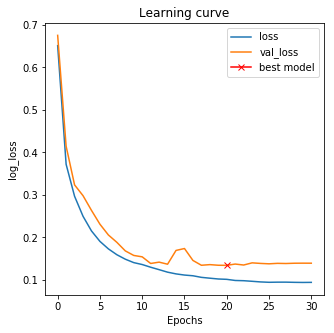

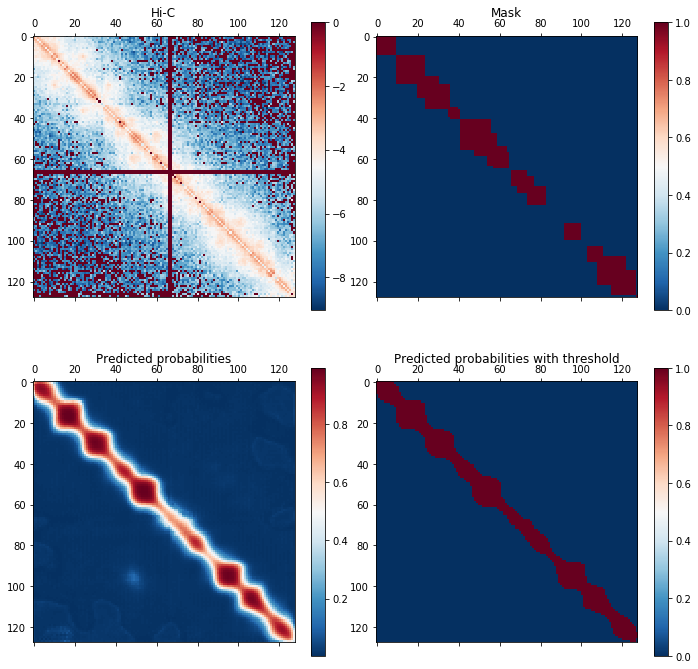

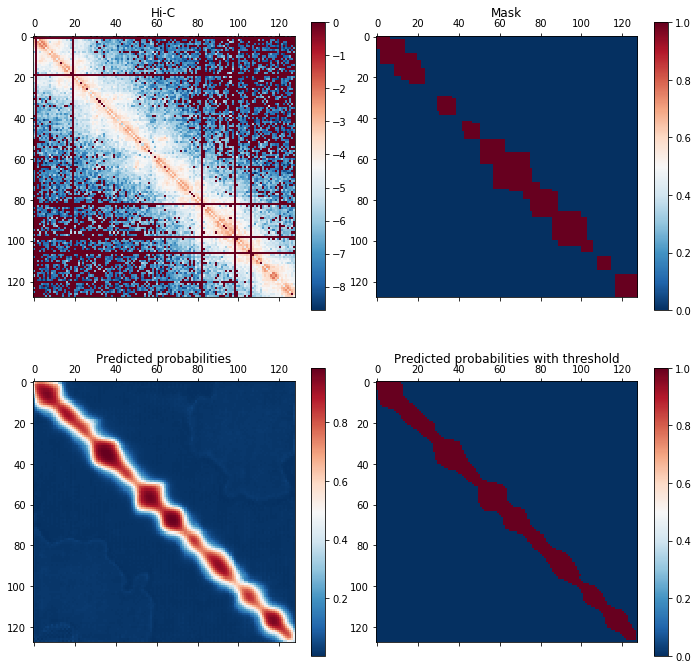

In [16]:
eval_model(image_size = 128, is_log=True, is_norm_over_diagonals=False)

Train on 21 samples, validate on 4 samples
Epoch 1/100
21/21 [==============================] - 91s 4s/step - loss: 0.8603 - acc: 0.4134 - val_loss: 2.4761 - val_acc: 0.4056

Epoch 00001: val_loss improved from inf to 2.47608, saving model to weights/model_unet_256_log.h5
Epoch 2/100
21/21 [==============================] - 31s 1s/step - loss: 0.5616 - acc: 0.9390 - val_loss: 0.7690 - val_acc: 0.8623

Epoch 00002: val_loss improved from 2.47608 to 0.76896, saving model to weights/model_unet_256_log.h5
Epoch 3/100
21/21 [==============================] - 29s 1s/step - loss: 0.4760 - acc: 0.9699 - val_loss: 0.5531 - val_acc: 0.9381

Epoch 00003: val_loss improved from 0.76896 to 0.55308, saving model to weights/model_unet_256_log.h5
Epoch 4/100
21/21 [==============================] - 27s 1s/step - loss: 0.4303 - acc: 0.9703 - val_loss: 1.0414 - val_acc: 0.8635

Epoch 00004: val_loss did not improve from 0.55308
Epoch 5/100
21/21 [==============================] - 27s 1s/step - loss: 0.3

Epoch 37/100
21/21 [==============================] - 26s 1s/step - loss: 0.1093 - acc: 0.9776 - val_loss: 0.1135 - val_acc: 0.9734

Epoch 00037: val_loss did not improve from 0.11328
Epoch 38/100
21/21 [==============================] - 24s 1s/step - loss: 0.1084 - acc: 0.9776 - val_loss: 0.1125 - val_acc: 0.9739

Epoch 00038: val_loss improved from 0.11328 to 0.11248, saving model to weights/model_unet_256_log.h5
Epoch 39/100
21/21 [==============================] - 24s 1s/step - loss: 0.1071 - acc: 0.9780 - val_loss: 0.1121 - val_acc: 0.9736

Epoch 00039: val_loss improved from 0.11248 to 0.11207, saving model to weights/model_unet_256_log.h5
Epoch 40/100
21/21 [==============================] - 25s 1s/step - loss: 0.1070 - acc: 0.9775 - val_loss: 0.1115 - val_acc: 0.9740

Epoch 00040: val_loss improved from 0.11207 to 0.11148, saving model to weights/model_unet_256_log.h5
Epoch 41/100
21/21 [==============================] - 25s 1s/step - loss: 0.1057 - acc: 0.9778 - val_loss: 0.11


Epoch 00074: val_loss did not improve from 0.09664
Epoch 75/100
21/21 [==============================] - 29s 1s/step - loss: 0.0782 - acc: 0.9825 - val_loss: 0.0969 - val_acc: 0.9730

Epoch 00075: val_loss did not improve from 0.09664
Epoch 76/100
21/21 [==============================] - 34s 2s/step - loss: 0.0778 - acc: 0.9826 - val_loss: 0.0969 - val_acc: 0.9730

Epoch 00076: ReduceLROnPlateau reducing learning rate to 1e-05.

Epoch 00076: val_loss did not improve from 0.09664
Epoch 77/100
21/21 [==============================] - 28s 1s/step - loss: 0.0780 - acc: 0.9824 - val_loss: 0.0968 - val_acc: 0.9730

Epoch 00077: val_loss did not improve from 0.09664
Epoch 78/100
21/21 [==============================] - 29s 1s/step - loss: 0.0773 - acc: 0.9829 - val_loss: 0.0967 - val_acc: 0.9730

Epoch 00078: val_loss did not improve from 0.09664
Epoch 79/100
21/21 [==============================] - 27s 1s/step - loss: 0.0778 - acc: 0.9825 - val_loss: 0.0969 - val_acc: 0.9730

Epoch 00079: v

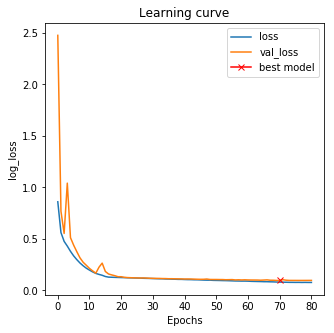

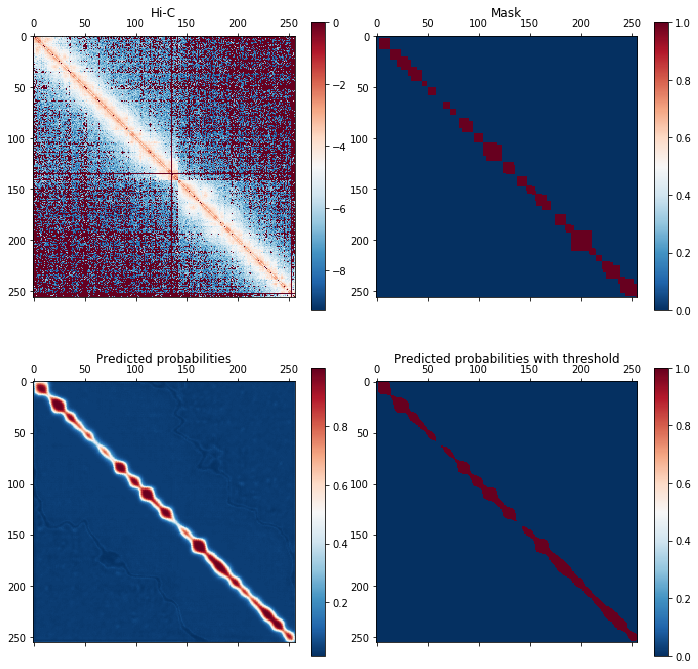

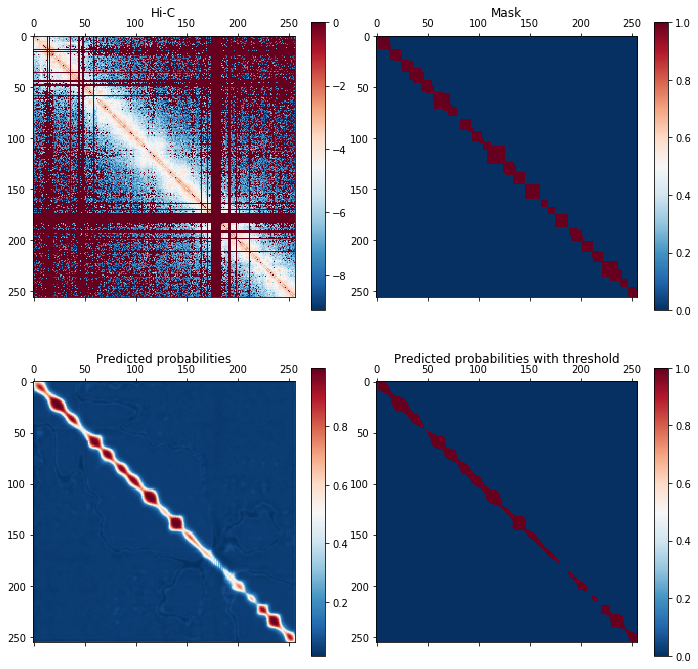

In [17]:
eval_model(image_size = 256, is_log=True, is_norm_over_diagonals=False)

log, normalized over diagonals

Train on 158 samples, validate on 28 samples
Epoch 1/100
158/158 [==============================] - 100s 632ms/step - loss: 0.5602 - acc: 0.7359 - val_loss: 0.4730 - val_acc: 0.8039

Epoch 00001: val_loss improved from inf to 0.47301, saving model to weights/model_unet_32_norm_log.h5
Epoch 2/100
158/158 [==============================] - 29s 184ms/step - loss: 0.3785 - acc: 0.8319 - val_loss: 0.4418 - val_acc: 0.8045

Epoch 00002: val_loss improved from 0.47301 to 0.44185, saving model to weights/model_unet_32_norm_log.h5
Epoch 3/100
158/158 [==============================] - 27s 173ms/step - loss: 0.3524 - acc: 0.8417 - val_loss: 0.3939 - val_acc: 0.8246

Epoch 00003: val_loss improved from 0.44185 to 0.39394, saving model to weights/model_unet_32_norm_log.h5
Epoch 4/100
158/158 [==============================] - 31s 194ms/step - loss: 0.3392 - acc: 0.8490 - val_loss: 0.3999 - val_acc: 0.8149

Epoch 00004: val_loss did not improve from 0.39394
Epoch 5/100
158/158 [====================

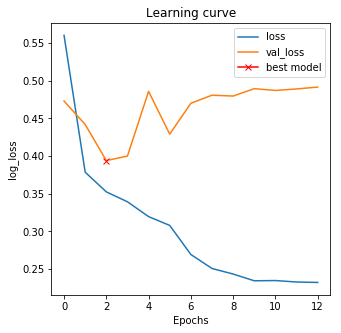

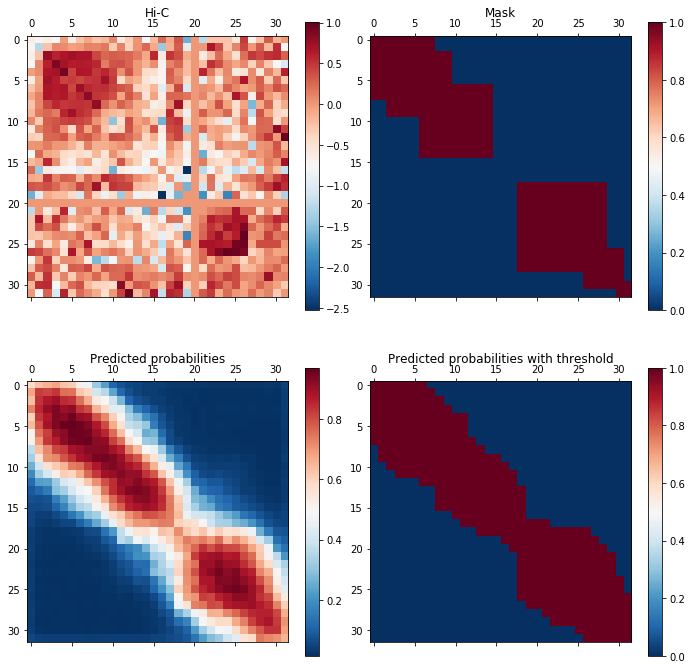

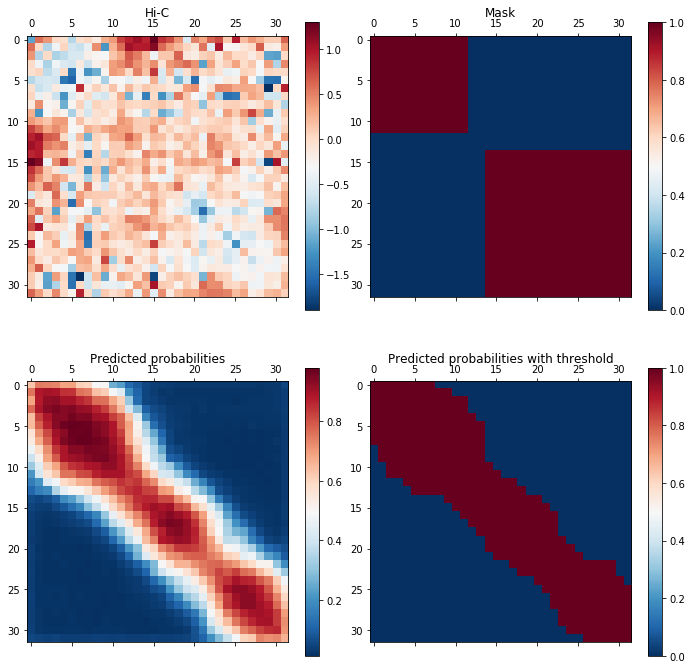

In [18]:
eval_model(image_size = 32, is_log=True, is_norm_over_diagonals=True)

Train on 80 samples, validate on 14 samples
Epoch 1/100
80/80 [==============================] - 81s 1s/step - loss: 0.3653 - acc: 0.8508 - val_loss: 0.2795 - val_acc: 0.9089

Epoch 00001: val_loss improved from inf to 0.27953, saving model to weights/model_unet_64_norm_log.h5
Epoch 2/100
80/80 [==============================] - 17s 216ms/step - loss: 0.2330 - acc: 0.9071 - val_loss: 0.2298 - val_acc: 0.9122

Epoch 00002: val_loss improved from 0.27953 to 0.22982, saving model to weights/model_unet_64_norm_log.h5
Epoch 3/100
80/80 [==============================] - 18s 219ms/step - loss: 0.2077 - acc: 0.9125 - val_loss: 0.2172 - val_acc: 0.9092

Epoch 00003: val_loss improved from 0.22982 to 0.21716, saving model to weights/model_unet_64_norm_log.h5
Epoch 4/100
80/80 [==============================] - 17s 217ms/step - loss: 0.1958 - acc: 0.9149 - val_loss: 0.2774 - val_acc: 0.8762

Epoch 00004: val_loss did not improve from 0.21716
Epoch 5/100
80/80 [==============================] - 1

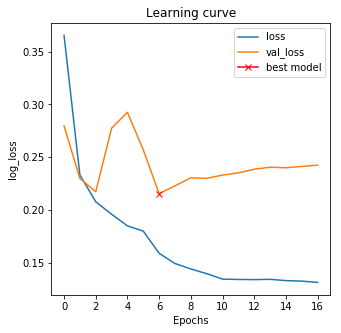

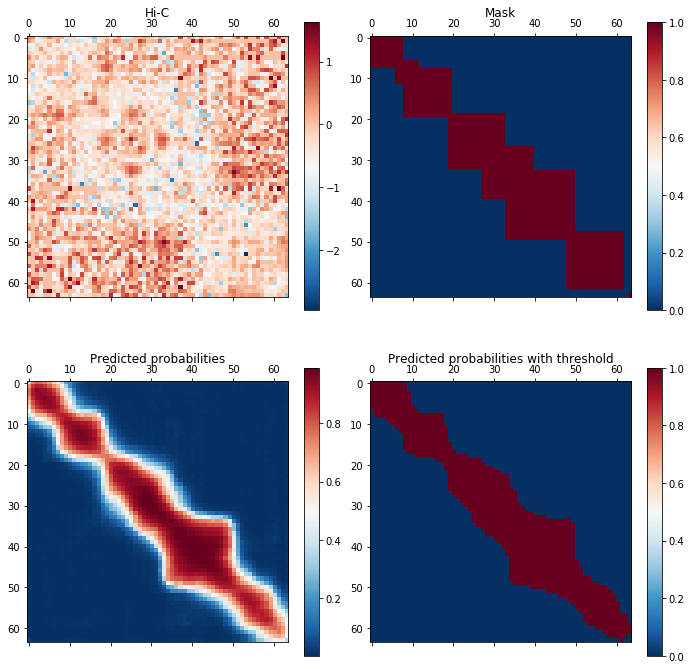

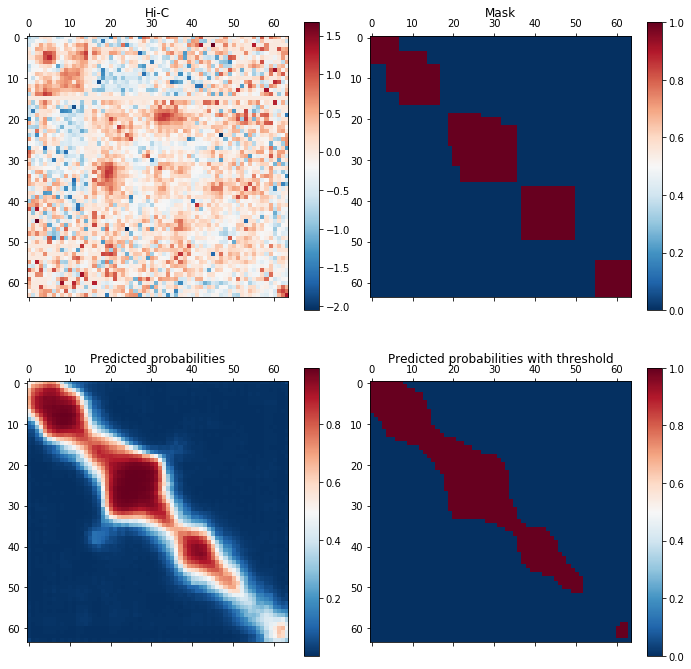

In [19]:
eval_model(image_size = 64, is_log=True, is_norm_over_diagonals=True)

Train on 41 samples, validate on 7 samples
Epoch 1/100
41/41 [==============================] - 90s 2s/step - loss: 0.4329 - acc: 0.8566 - val_loss: 0.3920 - val_acc: 0.9391

Epoch 00001: val_loss improved from inf to 0.39197, saving model to weights/model_unet_128_norm_log.h5
Epoch 2/100
41/41 [==============================] - 17s 416ms/step - loss: 0.2390 - acc: 0.9455 - val_loss: 0.2364 - val_acc: 0.9432

Epoch 00002: val_loss improved from 0.39197 to 0.23640, saving model to weights/model_unet_128_norm_log.h5
Epoch 3/100
41/41 [==============================] - 17s 418ms/step - loss: 0.1778 - acc: 0.9508 - val_loss: 0.2421 - val_acc: 0.9370

Epoch 00003: val_loss did not improve from 0.23640
Epoch 4/100
41/41 [==============================] - 17s 414ms/step - loss: 0.1505 - acc: 0.9534 - val_loss: 0.1881 - val_acc: 0.9325

Epoch 00004: val_loss improved from 0.23640 to 0.18808, saving model to weights/model_unet_128_norm_log.h5
Epoch 5/100
41/41 [==============================] -

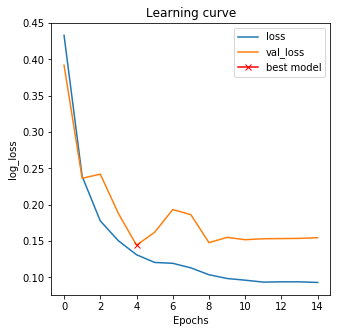

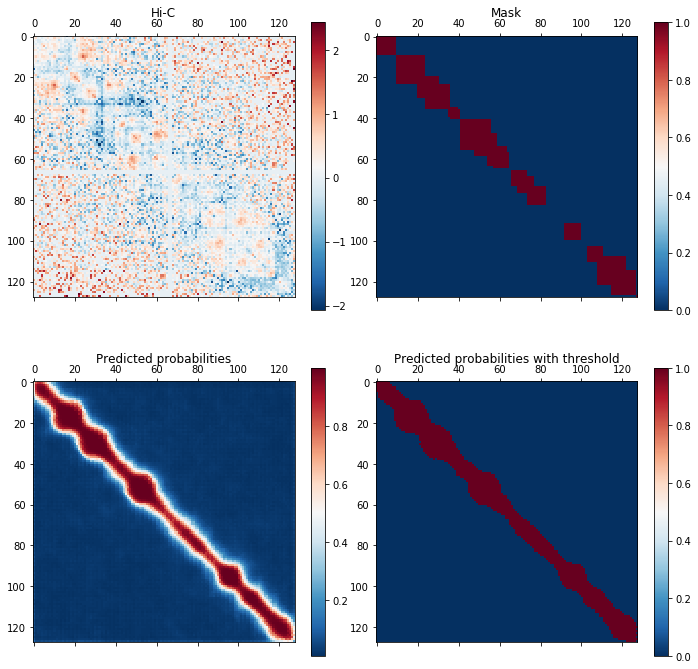

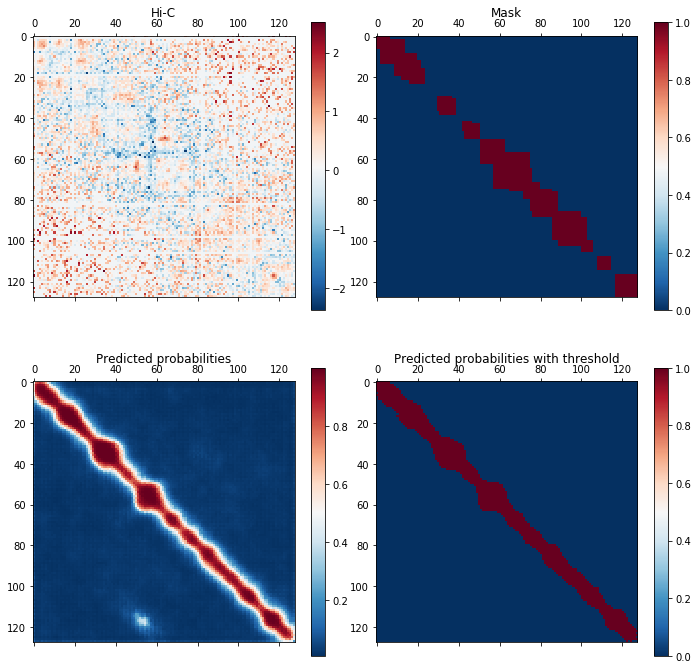

In [20]:
eval_model(image_size = 128, is_log=True, is_norm_over_diagonals=True)

Train on 21 samples, validate on 4 samples
Epoch 1/100
21/21 [==============================] - 89s 4s/step - loss: 0.9631 - acc: 0.3026 - val_loss: 6.1142 - val_acc: 0.3199

Epoch 00001: val_loss improved from inf to 6.11419, saving model to weights/model_unet_256_norm_log.h5
Epoch 2/100
21/21 [==============================] - 24s 1s/step - loss: 0.5936 - acc: 0.8323 - val_loss: 1.6803 - val_acc: 0.7175

Epoch 00002: val_loss improved from 6.11419 to 1.68031, saving model to weights/model_unet_256_norm_log.h5
Epoch 3/100
21/21 [==============================] - 23s 1s/step - loss: 0.4778 - acc: 0.9500 - val_loss: 0.5386 - val_acc: 0.9275

Epoch 00003: val_loss improved from 1.68031 to 0.53858, saving model to weights/model_unet_256_norm_log.h5
Epoch 4/100
21/21 [==============================] - 22s 1s/step - loss: 0.4226 - acc: 0.9594 - val_loss: 0.4610 - val_acc: 0.9515

Epoch 00004: val_loss improved from 0.53858 to 0.46098, saving model to weights/model_unet_256_norm_log.h5
Epoch

Train example 1
Test example 1


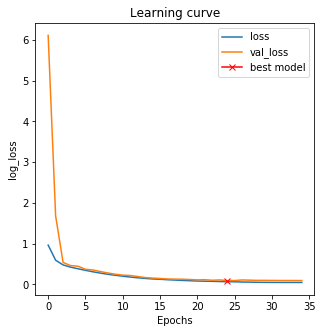

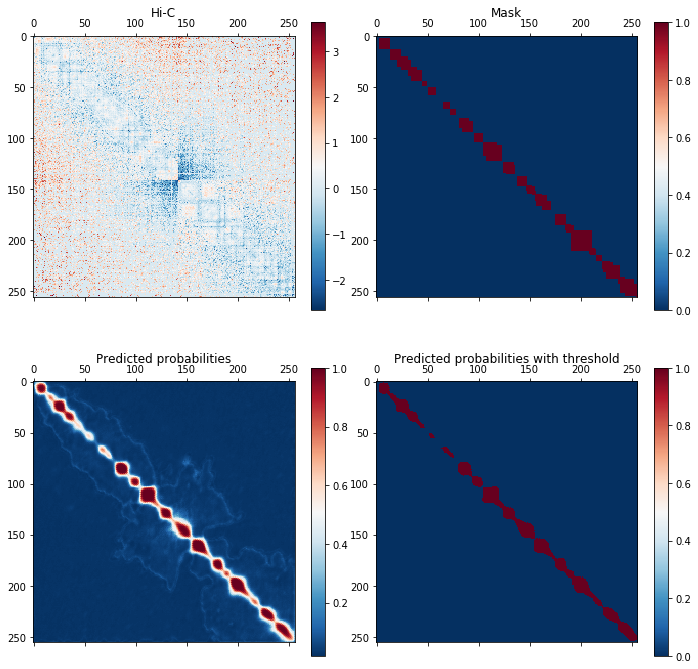

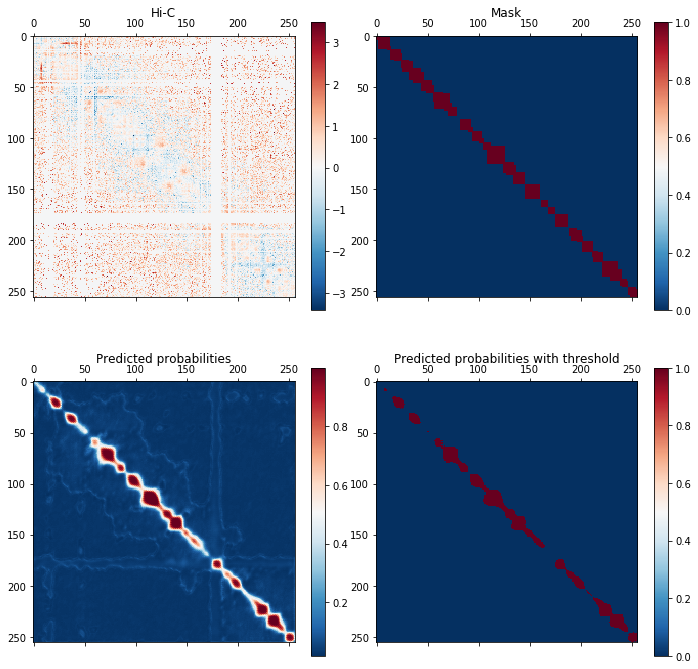

In [21]:
eval_model(image_size = 256, is_log=True, is_norm_over_diagonals=True)